In [3]:
import numpy as np
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
from torch import nn
import math
import seaborn as sns

%matplotlib inline

torch.Size([10000, 2])


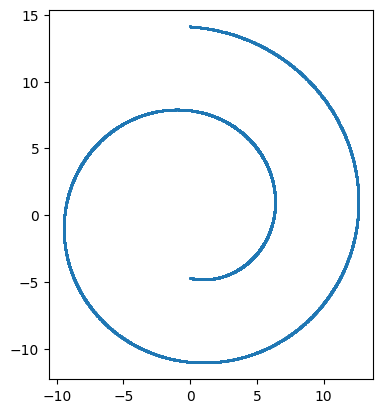

Data range: x=[-1.75, 1.61]
Data range: y=[-1.61, 1.99]


In [4]:
swiss_roll = make_swiss_roll(n_samples=10000,noise=0)[0][:,::2]
train_set = torch.tensor(swiss_roll).float()

mu, std = train_set.mean(0), train_set.std(0)
train_set = (train_set - mu)/std
print(train_set.shape)
plt.axes().set_aspect('equal')
plt.scatter(swiss_roll[:,0],swiss_roll[:,1], s=1)
plt.show()

print(f"Data range: x=[{train_set[:,0].min():.2f}, {train_set[:,0].max():.2f}]")
print(f"Data range: y=[{train_set[:,1].min():.2f}, {train_set[:,1].max():.2f}]")

In [6]:
# apparently it is more stable to use an ema of network
def init_ema(net, net_ema, ema_decay):
    for p, p_ema in zip(net.parameters(), net_ema.parameters()):
        p_ema.data.copy_(p.data)
        p_ema.requires_grad = False
    net_ema.ema_decay = ema_decay
    return net_ema


def update_ema(net, net_ema, num_updates, period=16):
    decay_effective = net_ema.ema_decay ** period  # period update to speedup
    if num_updates % period == 0:
        with torch.no_grad():
            for p, p_ema in zip(net.parameters(), net_ema.parameters()):
                # double precision to avoid numerical issues
                delta = p.data.double() - p_ema.data.double()
                p_ema_new = p_ema.data.double() + (1 - decay_effective) * delta
                p_ema.data.copy_(p_ema_new.float())

loss = 1.198310: 100%|███████████████████████████████████████| 20000/20000 [00:49<00:00, 404.58it/s]


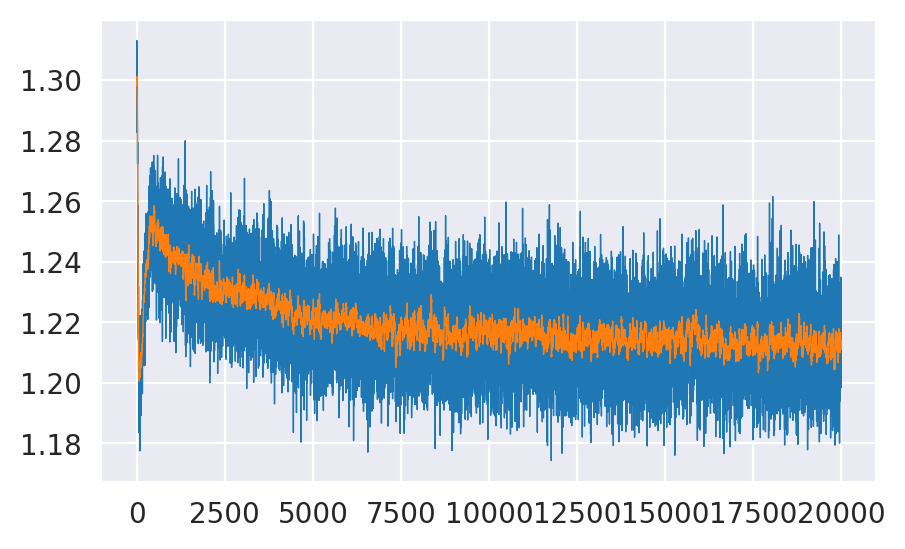

In [51]:
# Mean Flows for One-step Generative Modeling
# https://arxiv.org/pdf/2505.13447
import torch.nn.functional as F
from torch.func import jvp
# from torch.autograd.functional import jvp


def sample_t_r(batch_size, device):
    """Sample t between 0 and 1."""
    tr = torch.rand(batch_size,2, device=device)
    t = tr.max(dim=1)[0][:,None]
    r = tr.min(dim=1)[0][:,None]
    return t, r


def sample_t_r_stable(batch_size, device, min_gap=0.01):
    """Sample t and r with guaranteed minimum separation for stability"""
    # Method 1: Sample with guaranteed gap
    t = torch.rand(batch_size, 1, device=device) * (1.0 - 2*min_gap) + min_gap
    gap = torch.rand(batch_size, 1, device=device) * (t - min_gap) + min_gap
    r = t - gap

    # Ensure bounds
    t = torch.clamp(t, min_gap, 1.0 - min_gap)
    r = torch.clamp(r, 0.0, 1.0 - 2*min_gap)

    return t, r


# https://github.com/haidog-yaqub/MeanFlow/blob/main/meanflow.py
def sample_t_r_gh(batch_size, device):
    mu, sigma = -0.4, 1.0
    flow_ratio = 0.5
    normal_samples = np.random.randn(batch_size, 2).astype(np.float32) * sigma + mu
    samples = 1 / (1 + np.exp(-normal_samples))  # Apply sigmoid

    # Assign t = max, r = min, for each pair
    t_np = np.maximum(samples[:, 0], samples[:, 1])
    r_np = np.minimum(samples[:, 0], samples[:, 1])

    num_selected = int(flow_ratio * batch_size)
    indices = np.random.permutation(batch_size)[:num_selected]
    r_np[indices] = t_np[indices]

    t = torch.tensor(t_np, device=device)[:,None]
    r = torch.tensor(r_np, device=device)[:,None]
    return t, r


def train_step(x, model, optimizer):
    """Mean Flow Identity Derivative leads to a definition
    for target average velocity u_tgt that depends on instantaneous velocity v and (t-r) times
    the time derivative of average velocity u. This is what we model here instead of v (unlike in FM)
    the total derivative of u is du/dz . dz/dt + du / dt . dt/dt (1) + du / dr . dr/dt (0)
    this can be computed using the JVP operator from forward Autodiff in torch.func.
    """
    #t,r = sample_t_r_gh(len(x), x.device)
    t,r = sample_t_r(len(x), x.device)

    e = torch.randn_like(x)
    z = (1-t) * x + t * e
    v = e - x


    dtdt = torch.ones_like(t)
    drdt = torch.zeros_like(r)


    def u_func(z, t, r):
        h = t - r
        return model(z, t, h)


    u, dudt = jvp(u_func, (z, t, r), (v, dtdt, drdt))
    u_tgt = v - (t-r) * dudt

    loss = (u - u_tgt.detach())**2

    loss = loss.sum(dim=1)
    norm_eps = 1e-3
    norm_p = 0.75
    adp_wt = (loss.detach() + norm_eps) ** norm_p
    loss = loss / adp_wt
    loss = loss.mean()


    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss



# problem of gradient?
class Residual(nn.Module):
    def __init__(self, num_in):
        super(Residual, self).__init__()
        self.lin = nn.Linear(num_in, num_in)

    def forward(self, x):
        y = F.gelu(self.lin(x)) + x
        return y


class TinyMLP(nn.Module):
    """Tiny MLP Conditioned on time"""
    def __init__(self, num_in, hidden):
        super(TinyMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_in + 2, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),

            # Residual(hidden),
            # Residual(hidden),
            # Residual(hidden),
            nn.GELU(),
            nn.Linear(hidden, num_in)
        )

    def forward(self, x, t, r):
        x_t = torch.cat((x, t, r), dim=1)
        return self.mlp(x_t)



def train(data, net, net_ema, niter, lr):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net.to(device)
    data = data.to(device)

    net_ema.to(device)
    init_ema(net, net_ema, 0.9999)

    optim = torch.optim.Adam(model.parameters(), lr=lr)
    batch_size = 2048
    losses = []
    for itr in (pbar := tqdm(range(niter), ncols=100)):
        idx = torch.randperm(len(data))[:batch_size]
        x = data[idx].contiguous()
        loss = train_step(x, model, optim)
        losses.append(loss.item())
        pbar.set_description(f"loss = {loss.item():06f}")
        update_ema(net, net_ema, itr)

    return losses


niter = 20000
lr = 3e-3
model = TinyMLP(2, 16)
model.train()

model_ema = TinyMLP(2, 16)

losses = train(train_set, model, model_ema, niter, lr)

from numpy.lib.stride_tricks import sliding_window_view
losses = np.array(losses)
losses_smooth = sliding_window_view(np.pad(losses, (10,10), mode='reflect'), 21).mean(axis=1)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1, figsize=(5, 3), dpi=200)
    ax.plot(np.arange(niter), losses, linewidth=0.5)
    ax.plot(np.arange(niter), losses_smooth, linewidth=0.5)
    plt.show()

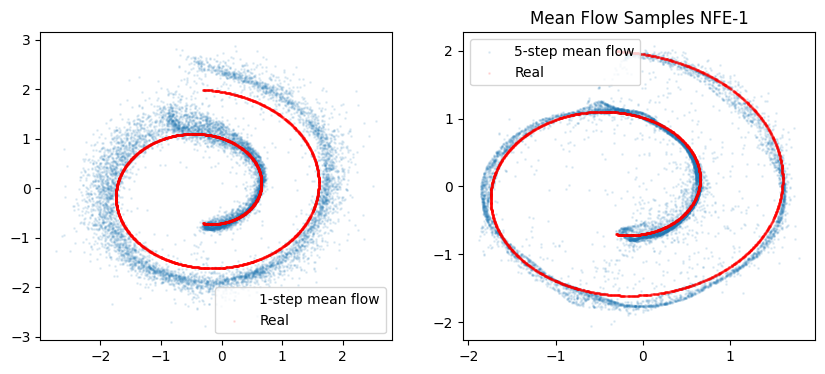

In [57]:
# 1 step sampling inference
@torch.no_grad()
def generate_samples_nfe1(model, n_samples):
    device = next(model.parameters()).device
    z = torch.randn(n_samples, 2).to(device)
    model.eval()
    r = torch.zeros((n_samples, 1), device=device)
    t = torch.ones((n_samples, 1), device=device)
    z = z - model(z, t, t-r)
    return z.cpu()


# n steps
@torch.no_grad()
def generate_samples_multistep(model, n_samples, sample_steps=5, device='cuda'):
    model.eval()

    z = torch.randn(n_samples, 2).to(device)

    t_vals = torch.linspace(1.0, 0.0, sample_steps + 1, device=device)

    for i in range(sample_steps):
        t = torch.full((z.size(0),1), t_vals[i], device=device)
        r = torch.full((z.size(0),1), t_vals[i + 1], device=device)

        v = model(z, r, t)
        z = z - (t-r) * v

    return z.cpu()

samples_nfen = generate_samples_multistep(model_ema, 10000, 5)
samples_nfe1 = generate_samples_nfe1(model, 10000)


plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
ax.scatter(samples_nfen[:, 0], samples_nfen[:, 1], alpha=0.1, s=1, label='1-step mean flow')
ax.scatter(train_set[:, 0], train_set[:, 1], alpha=0.1, s=1, color='red', label='Real')
plt.legend()
ax = plt.subplot(1, 2, 2)
ax.scatter(samples_nfe1[:, 0], samples_nfe1[:, 1], alpha=0.1, s=1, label='5-step mean flow')
ax.scatter(train_set[:, 0], train_set[:, 1], alpha=0.1, s=1, color='red', label='Real')
plt.legend()
plt.title('Mean Flow Samples NFE-1')
plt.show()